# Tutorial 05 - Features
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/schedldave/cv2021/blob/main/04_Edges.ipynb)
## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.


Useful links:
* OpenCV Tutorials: https://docs.opencv.org/master/d9/df8/tutorial_root.html
* Image Processing in Pyhton: https://github.com/xn2333/OpenCV/blob/master/Seminar_Image_Processing_in_Python.ipynb



# Table of Contents  

- Initialization
- Harris Corner Detector
- Histograms
- SIFT Descriptor
- Feature Matching
- Warping
- Everything Above


<a id="Initialization"></a>

# Initialization

As always let's import useful libraries, first. 
We will work with images today. So let's download some with `curl`.
Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [1]:
if 'google.colab' in str(get_ipython()):
  # install a newer opencv version on Colab. The default does not support SIFT!
  !pip install opencv-contrib-python==4.4.*

# import the libraries we use
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt



 
# loading images
!curl -o "woman.jpg" "https://live.staticflickr.com/8859/18045025168_3a1ffa6521_c_d.jpg"
!curl -o "foto1A.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg"
!curl -o "foto1B.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg"

# utility function(s)
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 56921    0 56921    0     0  56921      0 --:--:-- --:--:-- --:--:--  177k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  161k    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  161k  100  161k    0     0  55100      0  0:00:03  0:00:03 --:--:-- 52112
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   

# Harris Corner Detector


## OpenCV's Harris implementation

Let's first look at the implementation available with OpenCV. 
```
cv2.cornerHarris(src, blockSize, ksize, k)
```
The `cornerHarris` function takes an image, the window size, a size parameter for the Sobel operator and k, the Harris detector free parameter, as input.
Let's apply it to our example image.

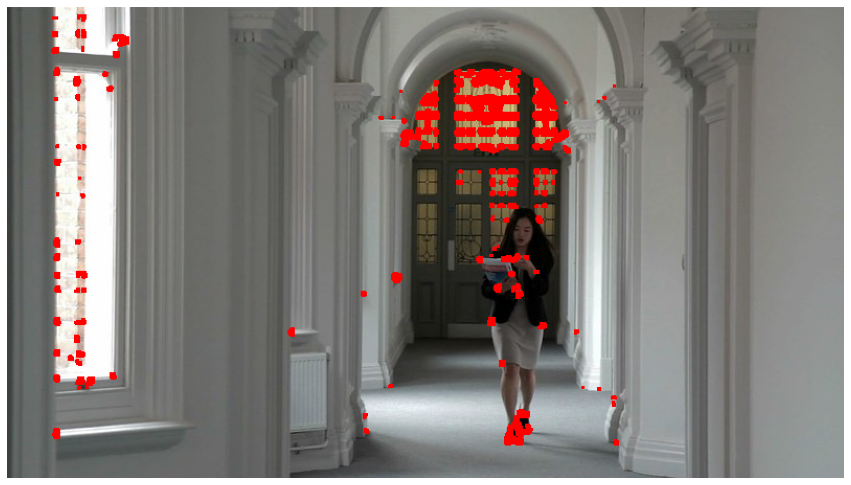

In [2]:
filename = "woman.jpg"
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dst = cv2.cornerHarris(gray.astype(np.float32),5,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]


plt.figure(figsize=(15,10))
imshow(img)
plt.show()


## Non-OpenCV implementation

To understand the algorithm better let's also look at an implementation without the builtin function of OpenCV. This implementation can also be found [online](https://github.com/hughesj919/HarrisCorner/blob/master/Corners.py). 
Note: the implementation is not very optimized and just for illustration. 
A local maximum suppression of R is not used.
Furthermore, it allows us to look at the computed R. 
Note that this implementation is using the alternative equation to compute the corner response $R$:
$$
R = \text{det}(M) - \alpha \thinspace \text{trace}(M)^2 = \lambda_1 \lambda_2 - \alpha (\lambda_1 + \lambda_2)^2
$$

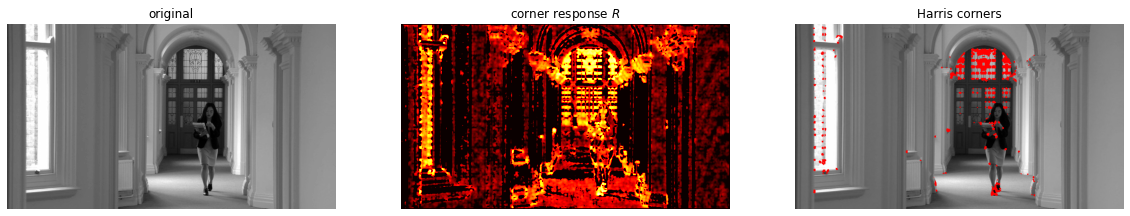

In [3]:
def findCorners(img, window_size=5, k=0.04, thresh=10000 ):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]

    cornerList = []
    newImg = img.copy()
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB)
    offset = int(window_size/2)
    R = np.zeros_like(dx)

    #Loop through image and find our corners
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)

            R[y,x] = r # store in R matrix

            #If corner response is over threshold, color the point and add to corner list
            if r > thresh:
                #print x, y, r
                cornerList.append([x, y, r])
                color_img.itemset((y, x, 0), 0)
                color_img.itemset((y, x, 1), 0)
                color_img.itemset((y, x, 2), 255)
    return color_img, R, cornerList


finalImg, R, cornerList = findCorners(gray, 5, 0.05, thresh=10000000)

# plotting
plt.figure(figsize=(20,15))
plt.subplot(131), imshow(gray, cmap='gray'), plt.title( 'original' )
response = R.copy()
response[R<0]=0 # remove negative values
plt.subplot(132), imshow(np.log(response+1.0), cmap='hot'), plt.title( 'corner response $R$' )
plt.subplot(133),imshow(finalImg), plt.title( 'Harris corners' ) 
plt.show()




# Histograms

## OpenCV's image histogram computation

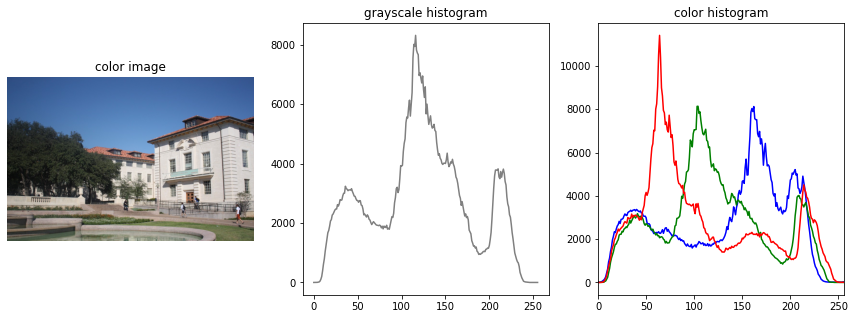

In [4]:
img = cv2.imread('foto1A.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert to grayscale

color = ('b','g','r')
plt.figure(figsize=(15,5)) # this command makes the figure larger so we see the images better
plt.subplot(131), imshow(img, cmap="gray"), plt.title('color image')

# grayscale
plt.subplot(132), plt.title('grayscale histogram')
histr = cv2.calcHist([gray],[0],None,[256],[0,256])
plt.plot(histr,color = 'gray')

# RGB
plt.subplot(133), plt.title('color histogram')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

plt.show()

## ⌨️ Try it yourself: Implement your own (grayscale) histogram function

Program an image histogram yourself. An 8-bit image can have 256 different values (0 to 255), use them as histogram bins.

(Python) Challenge(s): 
 - Can you do it in one line / as short as possible?
 - What happens if you modify the bin sizes?


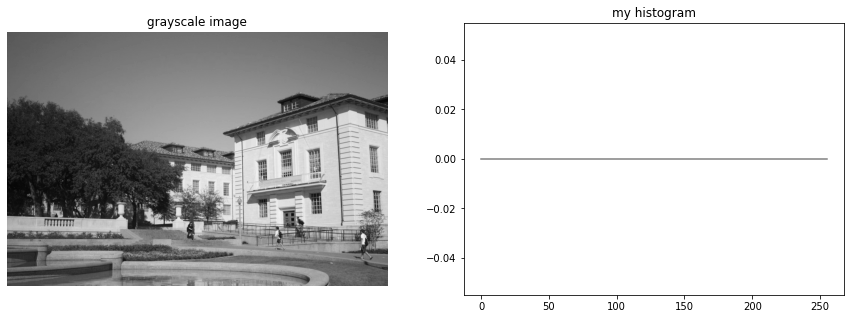

In [5]:
def compute_hist( gray ):
    assert len(gray.shape)==2 # make sure it is 2D and grayscale
    bins = np.zeros((256))

    # Todo

    return bins


# test it!
plt.figure(figsize=(15,5)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(gray, cmap="gray"), plt.title('grayscale image')
plt.subplot(122), plt.title('my histogram')
my_histr = compute_hist(gray)
plt.plot(my_histr,color = 'gray')
plt.show()

# SIFT Descriptor

## OpenCV's SIFT implementation

Make sure that you have a recent OpenCV version installed. SIFT was patented and is only free since 2020.



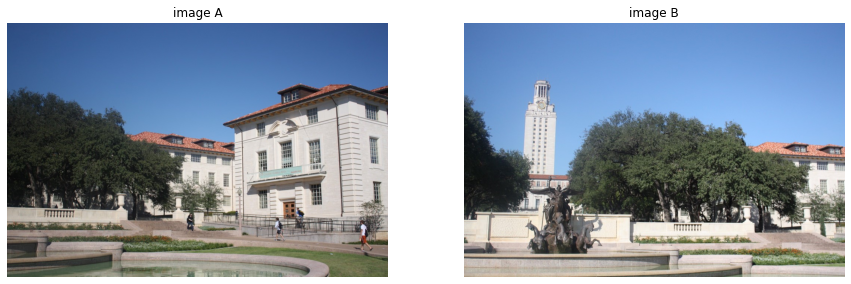

In [6]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed

imgA = cv2.imread("foto1A.jpg")
imgB = cv2.imread("foto1B.jpg")

# convert to grayscale
imgA_gray = cv2.cvtColor(imgA, cv2.COLOR_RGB2GRAY)
imgB_gray = cv2.cvtColor(imgB, cv2.COLOR_RGB2GRAY)


# display
plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(imgA, cmap="gray"), plt.title('image A')
plt.subplot(122), imshow(imgB, cmap="gray"), plt.title('image B')
plt.show()

(4233, 128)


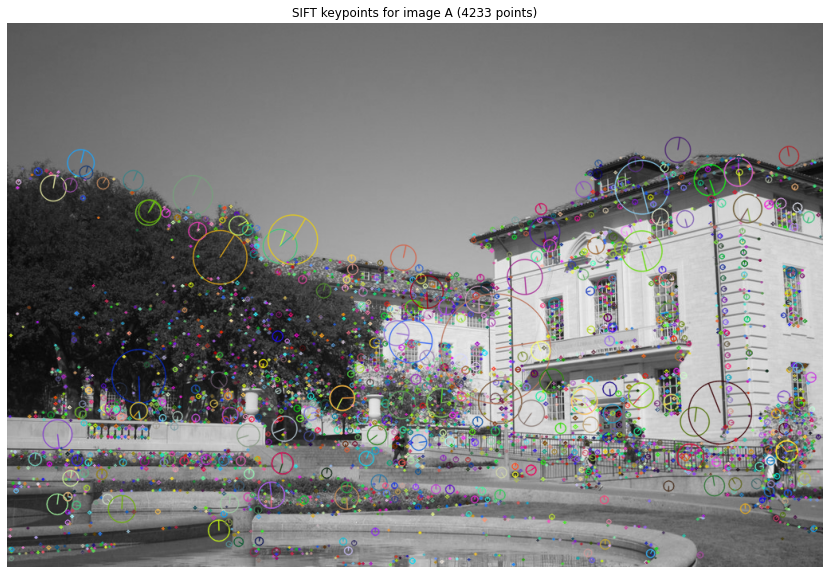

In [7]:
# init sift descriptor
sift = cv2.SIFT_create()

     
# get keypoints and descriptors
(kpsA, featuresA) = sift.detectAndCompute(imgA_gray, None)
print(featuresA.shape)

# display the keypoints
imgA_sift=cv2.drawKeypoints(imgA_gray,kpsA,imgA_gray.copy() ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display
plt.figure(figsize=(15,10)) # this command makes the figure larger so we see more details
#plt.subplot(121), imshow(imgA, cmap="gray"), plt.title('image 1')
imshow(imgA_sift, cmap="gray"), plt.title('SIFT keypoints for image A ({} points)'.format(featuresA.shape[0]))
plt.show()
    

Every interest point is descriped by a 128-dimensional feature vector. 
Let's display some as rows in an image.

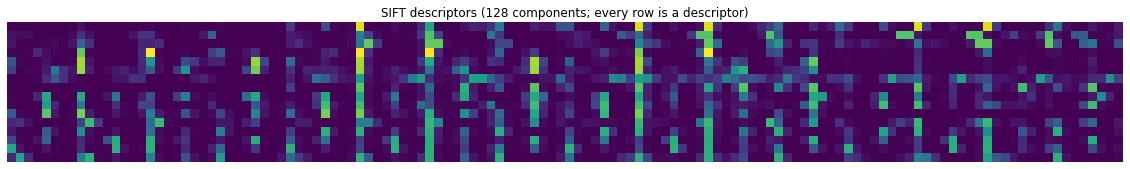

In [8]:
plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
imshow(featuresA[:16]), plt.title('SIFT descriptors (128 components; every row is a descriptor)')
plt.show()
#print(featuresA[0])

Furthermore, openCV provides implementations for other descriptors such as SURF, ORB, and BRISK. 
You only need to replace `cv2.SIFT_create()` with another descriptor like `cv2.SURF_create()` or `cv2.BRISK_create()`.

# Feature Matching

Determine correspondence between interest points in two views by matching the feature descriptors. 

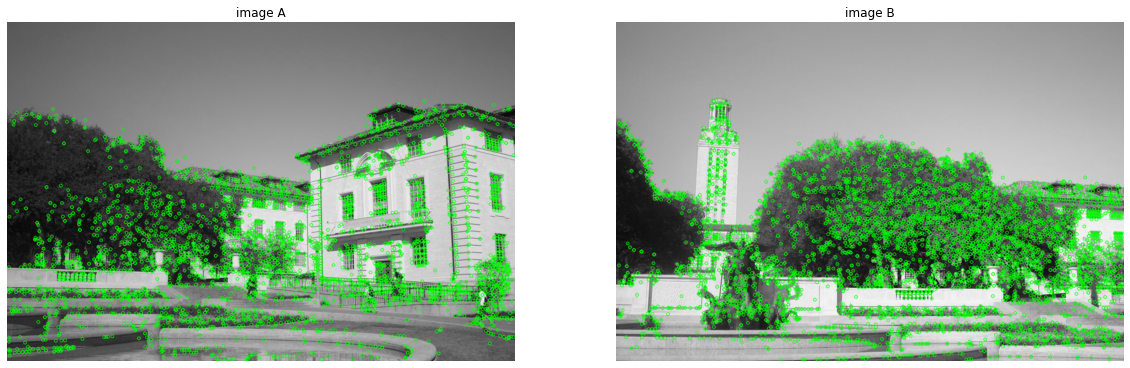

In [9]:
(kpsB, featuresB) = sift.detectAndCompute(imgB_gray, None) # compute features for second image

# display the keypoints and features detected on both images
plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(cv2.drawKeypoints(imgA_gray,kpsA,None,color=(0,255,0)), cmap="gray"), plt.title('image A')
plt.subplot(122), imshow(cv2.drawKeypoints(imgB_gray,kpsB,None,color=(0,255,0)), cmap="gray"), plt.title('image B')
plt.show()

plt.show()

## Simple Nearest Neighbour Matches

#matches (simple): 1837
match[0]:  29.832868576049805 0 4833 1605
match[100]:  67.86751556396484 0 4076 1167


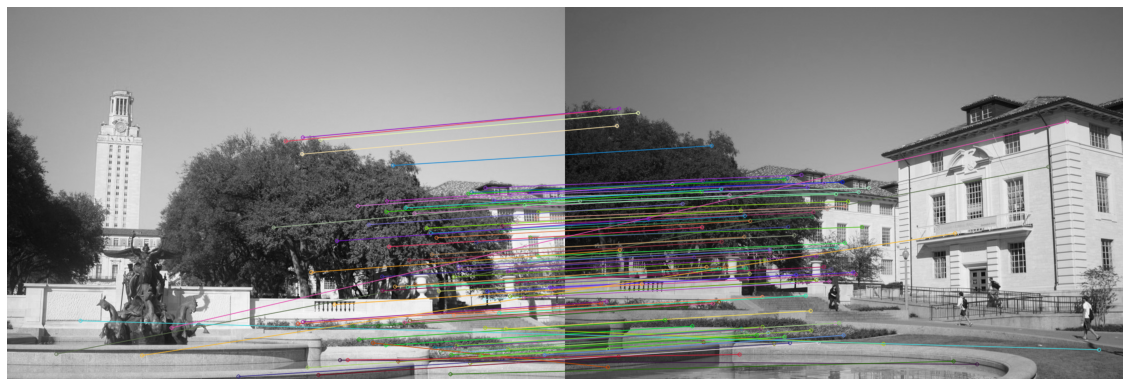

In [10]:
# Simple Nearest Neighbour Matches

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) # init OpenCV's matcher
    
# Match descriptors.
best_matches = bf.match(featuresB,featuresA)

# Sort the features in order of distance.
# The points with small distance (more similarity) are ordered first in the vector
matches = sorted(best_matches, key = lambda x:x.distance)
print("#matches (simple):", len(matches))
print("match[0]: ", matches[0].distance, matches[0].imgIdx, matches[0].queryIdx, matches[0].trainIdx)
print("match[100]: ", matches[100].distance, matches[100].imgIdx, matches[100].queryIdx, matches[100].trainIdx)

# display (some) matches
img_matches = cv2.drawMatches(imgB_gray,kpsB,imgA_gray,kpsA,matches[:1000:10],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
imshow(img_matches)
plt.show()


Let's look at the offsets of matched features and let's plot them. 

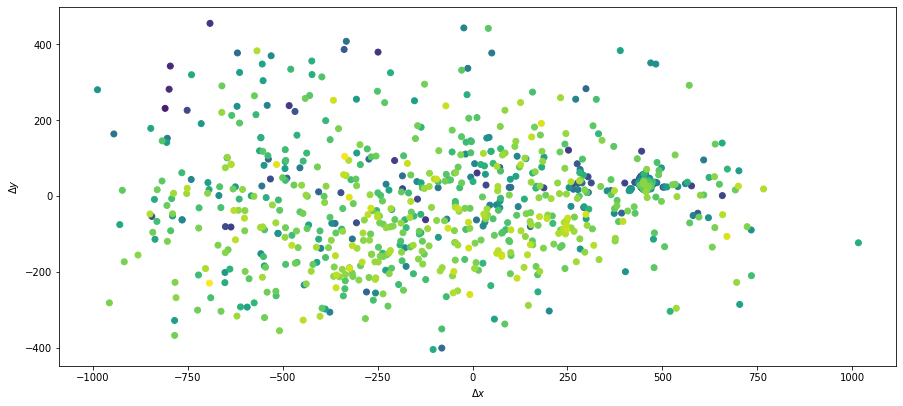

In [11]:
def getMatchedPoints(kpsA, kpsB, featuresA, featuresB, matches):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
       
        return (ptsA, ptsB)
    else:
        return None

(ptsA, ptsB) =    getMatchedPoints(kpsB, kpsA, featuresB, featuresA, matches[:])

diff = ptsA - ptsB # compute offsets between matched points
simDistance = np.float32([m.distance for m in matches])

# display
fig = plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the images better
ax = fig.add_subplot(111)
plt.scatter(diff[:,0],diff[:,1],c=simDistance,cmap='viridis')
ax.set_aspect('equal', adjustable='box'), plt.xlabel('$\Delta x$'), plt.ylabel('$\Delta y$')
plt.show()

 ## Nearest Neigbhor Distance Ratio

#Matches (KNN Distance Ratio): 712
match[0]:  29.832868576049805 0 4833 1605
match[100]:  69.83551788330078 0 4881 1700


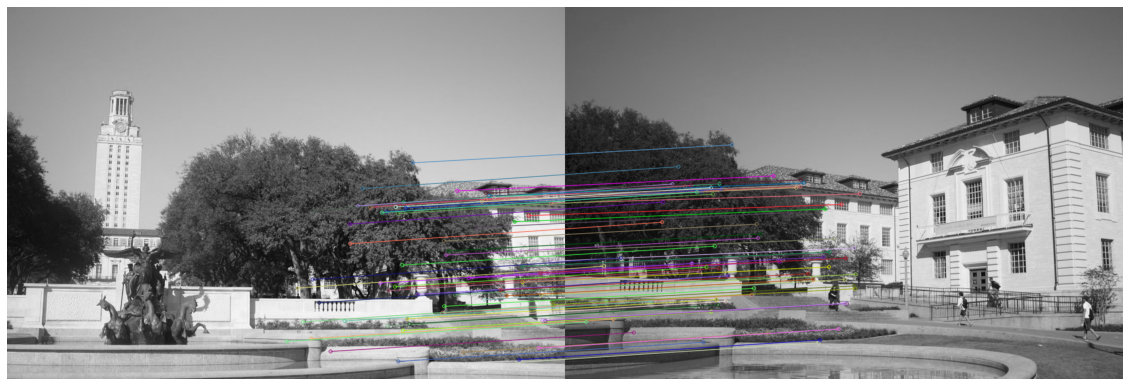

In [12]:
# Nearest Neigbhor Distance Ratio
ratio = 0.5 # optionally use .75
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False) # init OpenCV's matcher

rawMatches = bf.knnMatch(featuresB, featuresA, 2) # retrieves the two nearest neighbours
matches = []

# loop over the raw matches
for m,n in rawMatches:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe's ratio test)
    if m.distance < n.distance * ratio:
        matches.append(m)

# sort based on the distance of the closest neighbour
matches = sorted(matches, key = lambda x:x.distance)

print("#Matches (KNN Distance Ratio):", len(matches))
print("match[0]: ", matches[0].distance, matches[0].imgIdx, matches[0].queryIdx, matches[0].trainIdx)
print("match[100]: ", matches[100].distance, matches[100].imgIdx, matches[100].queryIdx, matches[100].trainIdx)

# display (some) matches
img_matches = cv2.drawMatches(imgB_gray,kpsB,imgA_gray,kpsA,matches[:1000:10],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
imshow(img_matches)
plt.show()


Let's look at the offsets of matched features again. 
This has improved with the NN distance ratio matching!

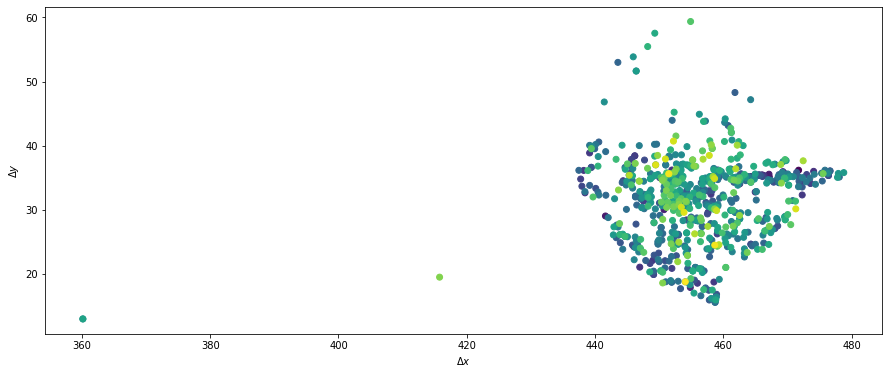

In [13]:
# plot the Δx and Δy of matches points
(ptsA, ptsB) =    getMatchedPoints(kpsB, kpsA, featuresB, featuresA, matches[:])

diff = ptsA - ptsB # compute offsets between matched points
simDistance = np.float32([m.distance for m in matches])

# display
fig = plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the images better
ax = fig.add_subplot(111)
plt.scatter(diff[:,0],diff[:,1],c=simDistance,cmap='viridis')
ax.set_aspect('equal', adjustable='box'), plt.xlabel('$\Delta x$'), plt.ylabel('$\Delta y$')
plt.show()

# Warping

## Simple Translational Model

Let's merge the two images by translating/warping one image (image A). 
So we assume that a point $\bf x$ in one image corresponds to $\bf x' = \bf x + \bf t$ in the second image, where $\bf t$ is the translation.

[[  1.         0.       456.448   ]
 [  0.         1.        32.420303]]


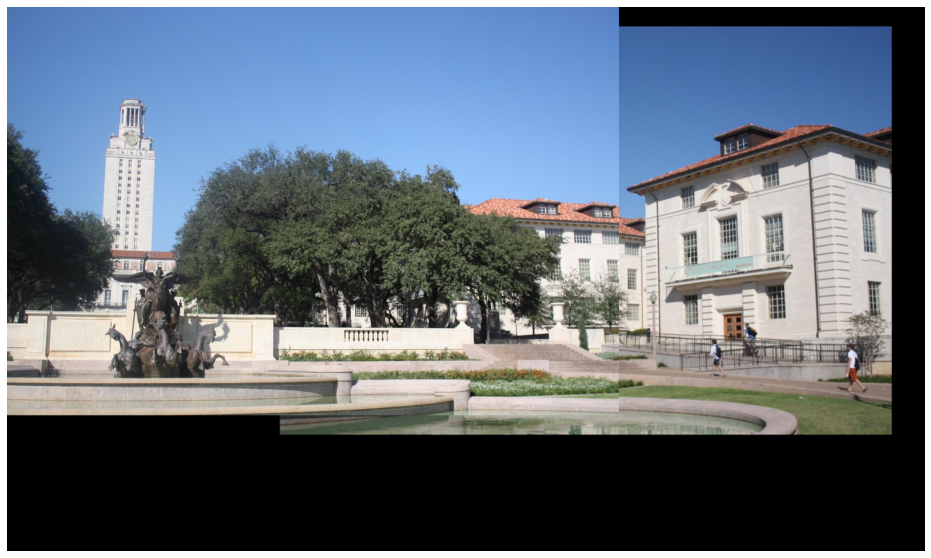

In [17]:
num_best_matches = int(len(matches)/2) # only use the best matches

# estimate the image translation with the offset of matched points
shiftX, shiftY = np.median(diff[:num_best_matches,0]), np.median(diff[:num_best_matches,1])
H = np.float32([
	[1, 0, shiftX],
	[0, 1, shiftY]
])
print(H) # print the translation matrix

# make sure the new image is large enough
width  = imgA.shape[1] + int(imgB.shape[1]/2)
height = imgA.shape[0] + int(imgB.shape[0]/3)

# warp image A to image B
result = cv2.warpAffine(imgA, H, (width, height))
result[0:imgB.shape[0], 0:imgB.shape[1]] = imgB

plt.figure(figsize=(20,10))
imshow(result)
plt.show()

## Perspective Transformation Model

As shown above, the assumption that a simple translation is enough to warp image A correctly onto B is not correct. The edges do not perfectly match because of this. 
Therefore, let's try to estimate a perspective transformation matrix (which has 8 degrees of freedom), which handles a variety of transformations.

[[ 7.58432483e-01  3.28916547e-02  4.48299841e+02]
 [-1.37084490e-01  9.06478040e-01  7.74177337e+01]
 [-2.14772246e-04 -3.71116963e-05  1.00000000e+00]]


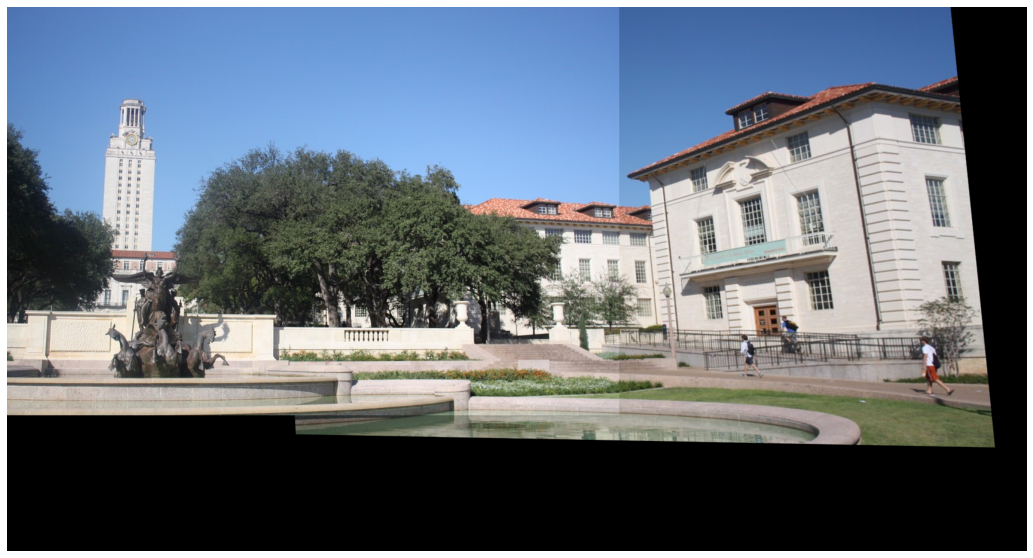

In [15]:
# estimate the homography between the sets of points
(H, status) = cv2.findHomography(ptsB, ptsA, cv2.RANSAC)
print(H) # the matrix is 3x3 now

# make sure the new image is large enough
width  = imgA.shape[1] + int(imgB.shape[1]*2/3)
height = imgA.shape[0] + int(imgB.shape[0]/3)

# warp image A to image B
result = cv2.warpPerspective(imgA, H, (width, height))
result[0:imgB.shape[0], 0:imgB.shape[1]] = imgB

plt.figure(figsize=(20,10))
imshow(result)
plt.show()


# Everything above (in one line): OpenCV's Image Stitcher 

We could have avoided all the steps above by simply using OpenCV's image stitcher. It does something similar like what we did above and also smoothly blends images. But where is the fun in that? 😃

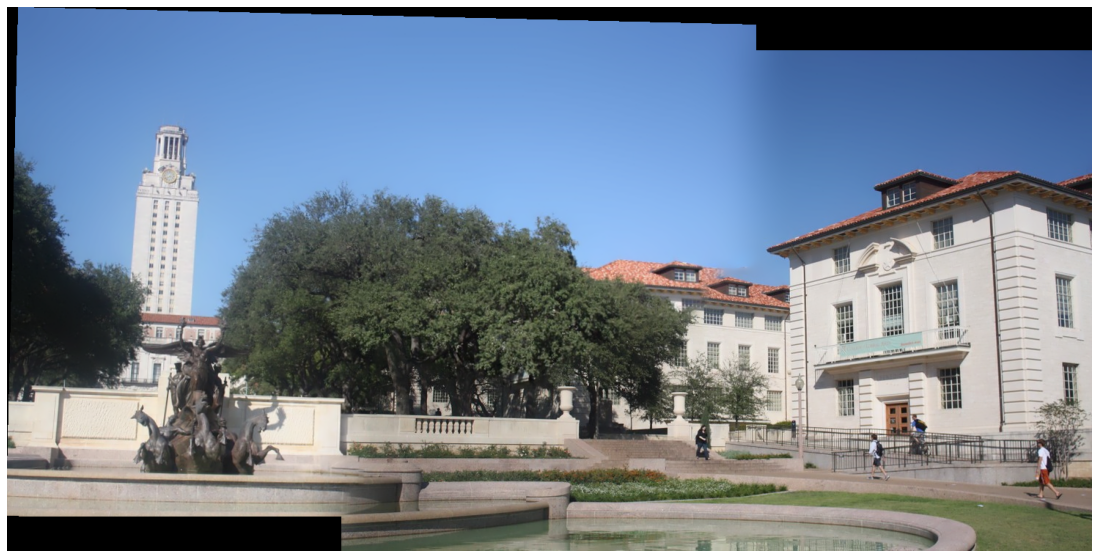

In [16]:
# initialize OpenCV's image stitcher object and then perform the image
# stitching
images = [imgA, imgB]
stitcher = cv2.Stitcher_create( mode=1 ) # mode=0 is panorama and assumes spherical stitichg, mode=1 is scan
(status, stitched) = stitcher.stitch(images)

if status==0: # stitching worked!
  plt.figure(figsize=(20,10))
  imshow(stitched)